# Comprehensive Multi-Domain Deepfake Detection with Attention Mechanisms

## Overview
This notebook implements a **complete multi-domain deepfake detection system** with attention mechanisms, combining and improving upon three approaches:

### Multi-Domain Feature Extraction:
1. **Spatial Domain (Xception)**: Fine-grained texture and pixel-level artifact detection
2. **Frequency Domain (FFT)**: Frequency spectrum analysis for periodic patterns
3. **Semantic Domain (DINOv2)**: High-level semantic feature extraction

### Model Implementations:
- **Individual Domain Models**: Separate classifiers for each domain
- **Baseline Fusion Model**: Simple concatenation-based fusion
- **Attention-Enhanced Fusion Model**: Learnable attention-weighted fusion
- **Complete Attention Model**: Individual attention + fusion attention

### Attention Mechanisms:
- **Channel Attention (SE)**: For spatial features
- **Frequency Band Attention**: For FFT features
- **Self-Attention**: For semantic features
- **Domain Attention Fusion**: Adaptive multi-domain weighting

---

## Table of Contents
1. [Setup & Configuration](#section1)
2. [Data Loading & Preprocessing](#section2)
3. [Face Detection & Extraction (MTCNN)](#section3)
4. [Feature Extraction](#section4)
5. [Attention Mechanisms Implementation](#section5)
6. [Individual Domain Models](#section6)
7. [Baseline Fusion Model](#section7)
8. [Attention-Enhanced Models](#section8)
9. [Comprehensive Model Comparison](#section9)
10. [Attention Analysis & Visualization](#section10)
11. [Ablation Study](#section11)
12. [Results Summary & Insights](#section12)

<a id='section1'></a>
## Section 1: Setup & Configuration

Import all necessary libraries and configure the project settings.

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

# Core libraries
import os
import numpy as np
import pandas as pd
import random
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Models
import timm
from facenet_pytorch import MTCNN

# Analysis and visualization
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'='*70}")
print("ENVIRONMENT SETUP")
print(f"{'='*70}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ Running on CPU - training will be slower")
print(f"PyTorch Version: {torch.__version__}")
print(f"{'='*70}")

ENVIRONMENT SETUP
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
GPU Memory: 6.00 GB
PyTorch Version: 2.7.1+cu118


In [37]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the entire pipeline."""
    
    # Paths
    BASE_DIR = Path('E:/deepfake_detection_project')
    FFPP_DIR = BASE_DIR / 'FaceForensics++'
    PREPROCESSED_DIR = BASE_DIR / 'preprocessed_faces'
    FEATURES_DIR = BASE_DIR / 'extracted_features'
    CHECKPOINTS_DIR = BASE_DIR / 'checkpoints'
    RESULTS_DIR = BASE_DIR / 'results'
    METADATA_PATH = BASE_DIR / 'ffpp_metadata.csv'
    
    # Data settings
    DEMO_LIMIT = 50  # Videos per category (None for full dataset)
    FRAMES_PER_VIDEO = 20
    FACE_SIZE = 299
    TRAIN_RATIO = 0.8
    
    # Feature dimensions
    SPATIAL_DIM = 2048   # Xception output
    FREQ_DIM = 4         # FFT statistical features
    SEMANTIC_DIM = 768   # DINOv2 ViT-B/14 output (Base model)
    
    # Training settings
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-4
    EPOCHS = 15
    HIDDEN_DIM1 = 512
    HIDDEN_DIM2 = 256
    DROPOUT = 0.5
    FUSION_DIM = 512
    
    # Early stopping
    PATIENCE = 5
    MIN_DELTA = 0.001

config = Config()

# Create directory structure
def create_directories():
    """Create all necessary directories."""
    dirs = [
        config.PREPROCESSED_DIR,
        config.FEATURES_DIR / 'spatial',
        config.FEATURES_DIR / 'frequency',
        config.FEATURES_DIR / 'semantic',
        config.CHECKPOINTS_DIR,
        config.RESULTS_DIR
    ]
    for dir_path in dirs:
        dir_path.mkdir(parents=True, exist_ok=True)
    print("✓ Directory structure created")

create_directories()

# Display configuration
print(f"\n{'='*70}")
print("PROJECT CONFIGURATION")
print(f"{'='*70}")
print(f"Base Directory: {config.BASE_DIR.absolute()}")
print(f"Dataset: FaceForensics++")
print(f"Mode: {'Demo (' + str(config.DEMO_LIMIT) + ' videos/category)' if config.DEMO_LIMIT else 'Full dataset'}")
print(f"Frames per video: {config.FRAMES_PER_VIDEO}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Feature dimensions: Spatial={config.SPATIAL_DIM}, Freq={config.FREQ_DIM}, Semantic={config.SEMANTIC_DIM}")
print(f"{'='*70}")

✓ Directory structure created

PROJECT CONFIGURATION
Base Directory: E:\deepfake_detection_project
Dataset: FaceForensics++
Mode: Demo (50 videos/category)
Frames per video: 20
Batch size: 128
Learning rate: 0.0001
Epochs: 15
Feature dimensions: Spatial=2048, Freq=4, Semantic=768


<a id='section2'></a>
## Section 2: Data Loading & Preprocessing

Generate metadata from FaceForensics++ dataset structure.

In [38]:
def generate_metadata(ffpp_dir, output_path, limit_per_category=None):
    """
    Generate metadata CSV file for FaceForensics++ dataset.
    
    Args:
        ffpp_dir: Root directory of FaceForensics++ dataset
        output_path: Path to save metadata CSV
        limit_per_category: Limit number of videos per category
    """
    print(f"\n{'='*70}")
    print("GENERATING METADATA")
    print(f"{'='*70}")
    
    data = []
    
    # Find original (real) videos
    original_dirs = ['original', 'original_sequences', 'youtube', 'real']
    for dir_name in original_dirs:
        original_dir = ffpp_dir / dir_name
        if original_dir.exists():
            videos = list(original_dir.rglob('*.mp4')) + list(original_dir.rglob('*.avi'))
            if limit_per_category:
                videos = videos[:limit_per_category]
            for video_path in videos:
                data.append({
                    'video_id': video_path.stem,
                    'label': 'real',
                    'path': str(video_path),
                    'manipulation': 'Original'
                })
            print(f"✓ Found {len(videos)} original videos in '{dir_name}'")
            break
    
    # Find manipulated (fake) videos
    manipulation_methods = [
        'Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures',
        'FaceShifter', 'DeepFakeDetection'
    ]
    
    for method in manipulation_methods:
        for variant in [method, method.lower()]:
            method_dir = ffpp_dir / variant
            if method_dir.exists():
                videos = list(method_dir.rglob('*.mp4')) + list(method_dir.rglob('*.avi'))
                if limit_per_category:
                    videos = videos[:limit_per_category]
                for video_path in videos:
                    data.append({
                        'video_id': f"{method}_{video_path.stem}",
                        'label': 'fake',
                        'path': str(video_path),
                        'manipulation': method
                    })
                print(f"✓ Found {len(videos)} {method} videos")
                break
    
    # Save metadata
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    
    print(f"\n{'='*70}")
    print(f"Metadata saved to: {output_path}")
    print(f"Total videos: {len(df)}")
    print(f"Real: {len(df[df['label'] == 'real'])}, Fake: {len(df[df['label'] == 'fake'])}")
    print(f"{'='*70}")
    
    return df

def load_or_generate_metadata():
    """Load existing metadata or generate new one."""
    if config.METADATA_PATH.exists():
        try:
            df = pd.read_csv(config.METADATA_PATH)
            if len(df) > 0:
                print(f"✓ Loaded metadata: {len(df)} videos")
                return df
        except Exception:
            pass
    
    return generate_metadata(config.FFPP_DIR, config.METADATA_PATH, config.DEMO_LIMIT)

# Load metadata
metadata_df = load_or_generate_metadata()

# Display statistics
print("\nDataset Statistics:")
print(metadata_df['manipulation'].value_counts())

✓ Loaded metadata: 350 videos

Dataset Statistics:
manipulation
Original             50
Deepfakes            50
Face2Face            50
FaceSwap             50
NeuralTextures       50
FaceShifter          50
DeepFakeDetection    50
Name: count, dtype: int64


<a id='section3'></a>
## Section 3: Face Detection & Extraction (MTCNN)

Extract faces from video frames using MTCNN for robust face detection.

In [39]:
def extract_faces_from_videos(metadata_df, output_dir, frames_per_video=20, image_size=299):
    """
    Extract faces from videos using MTCNN.
    
    Args:
        metadata_df: DataFrame with video metadata
        output_dir: Directory to save extracted faces
        frames_per_video: Number of frames to sample
        image_size: Output face image size
    """
    print(f"\n{'='*70}")
    print("FACE EXTRACTION WITH MTCNN")
    print(f"{'='*70}")
    
    # Initialize MTCNN
    mtcnn = MTCNN(
        image_size=image_size,
        margin=40,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],
        factor=0.709,
        post_process=True,
        keep_all=False,
        device=device
    )
    
    processed = 0
    skipped = 0
    errors = 0
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Extracting faces"):
        video_path = row['path']
        video_id = row['video_id']
        label = row['label']
        
        video_output_dir = output_dir / label / str(video_id)
        
        # Skip if already processed
        if video_output_dir.exists() and len(list(video_output_dir.glob('*.png'))) >= frames_per_video:
            skipped += 1
            continue
        
        video_output_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            cap = cv2.VideoCapture(str(video_path))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames == 0:
                errors += 1
                continue
            
            frame_indices = torch.linspace(0, total_frames - 1, frames_per_video).long()
            saved_count = 0
            
            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx.item())
                ret, frame = cap.read()
                
                if not ret:
                    continue
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face = mtcnn(frame_rgb)
                
                if face is not None:
                    save_path = video_output_dir / f'frame_{saved_count}.png'
                    face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                    face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(save_path), face_bgr)
                    saved_count += 1
                
                if saved_count >= frames_per_video:
                    break
            
            cap.release()
            processed += 1
            
        except Exception as e:
            errors += 1
    
    print(f"\n{'='*70}")
    print(f"Face extraction complete!")
    print(f"Processed: {processed}, Skipped: {skipped}, Errors: {errors}")
    print(f"{'='*70}")

# Run face extraction
extract_faces_from_videos(metadata_df, config.PREPROCESSED_DIR, 
                          config.FRAMES_PER_VIDEO, config.FACE_SIZE)


FACE EXTRACTION WITH MTCNN


Extracting faces:   0%|          | 0/350 [00:00<?, ?it/s]

Extracting faces: 100%|██████████| 350/350 [00:00<00:00, 1579.65it/s]


Face extraction complete!
Processed: 0, Skipped: 347, Errors: 3


<a id='section4'></a>
## Section 4: Feature Extraction

Extract features from all three domains: Spatial (Xception), Frequency (FFT), and Semantic (DINOv2).

In [40]:
# ============================================================================
# FEATURE EXTRACTORS
# ============================================================================

class SpatialExtractor(nn.Module):
    """XceptionNet-based spatial feature extractor (2048-dim)."""
    
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('xception', pretrained=True, num_classes=0)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()


class FrequencyExtractor:
    """FFT-based frequency feature extractor (4-dim: mean, var, skew, kurtosis)."""
    
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
    
    def extract(self, img_path):
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        
        # Apply 2D FFT
        f_transform = torch.fft.fft2(img_tensor)
        f_shift = torch.fft.fftshift(f_transform)
        magnitude_spectrum = torch.log(torch.abs(f_shift) + 1).numpy().flatten()
        
        # Statistical features
        return np.array([
            np.mean(magnitude_spectrum),
            np.var(magnitude_spectrum),
            skew(magnitude_spectrum),
            kurtosis(magnitude_spectrum)
        ], dtype=np.float32)


class SemanticExtractor(nn.Module):
    """DINOv2 ViT-B/14 semantic feature extractor (768-dim)."""
    
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', pretrained=True)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()

print("✓ Feature extractors defined:")
print(f"  - SpatialExtractor (Xception): {config.SPATIAL_DIM}-dim")
print(f"  - FrequencyExtractor (FFT): {config.FREQ_DIM}-dim")
print(f"  - SemanticExtractor (DINOv2): {config.SEMANTIC_DIM}-dim")

✓ Feature extractors defined:
  - SpatialExtractor (Xception): 2048-dim
  - FrequencyExtractor (FFT): 4-dim
  - SemanticExtractor (DINOv2): 768-dim


In [41]:
def extract_all_features(preprocessed_dir, output_dir):
    """Extract features from all three domains."""
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"\nFound {len(image_paths)} images to process")
    
    # Initialize extractors
    spatial_extractor = SpatialExtractor().to(device)
    freq_extractor = FrequencyExtractor()
    semantic_extractor = SemanticExtractor().to(device)
    
    extractors = {
        'spatial': (spatial_extractor, lambda e, p: e(p)),
        'frequency': (freq_extractor, lambda e, p: e.extract(p)),
        'semantic': (semantic_extractor, lambda e, p: e(p))
    }
    
    for domain, (extractor, extract_fn) in extractors.items():
        print(f"\n{'='*70}")
        print(f"EXTRACTING {domain.upper()} FEATURES")
        print(f"{'='*70}")
        
        processed = 0
        skipped = 0
        
        for img_path in tqdm(image_paths, desc=f"Extracting {domain}"):
            relative_path = img_path.relative_to(preprocessed_dir)
            feature_path = output_dir / domain / relative_path.with_suffix('.npy')
            
            if feature_path.exists():
                skipped += 1
                continue
            
            feature_path.parent.mkdir(parents=True, exist_ok=True)
            
            try:
                features = extract_fn(extractor, img_path)
                np.save(feature_path, features)
                processed += 1
            except Exception as e:
                print(f"Error: {e}")
        
        print(f"✓ {domain.capitalize()} complete: Processed={processed}, Skipped={skipped}")

# Run feature extraction
extract_all_features(config.PREPROCESSED_DIR, config.FEATURES_DIR)


Found 6997 images to process


Using cache found in C:\Users\ASUS/.cache\torch\hub\facebookresearch_dinov2_main



EXTRACTING SPATIAL FEATURES


Extracting spatial: 100%|██████████| 6997/6997 [00:00<00:00, 10365.75it/s]


✓ Spatial complete: Processed=0, Skipped=6997

EXTRACTING FREQUENCY FEATURES


Extracting frequency: 100%|██████████| 6997/6997 [00:00<00:00, 12620.62it/s]


✓ Frequency complete: Processed=0, Skipped=6997

EXTRACTING SEMANTIC FEATURES


Extracting semantic: 100%|██████████| 6997/6997 [00:00<00:00, 12983.23it/s]

✓ Semantic complete: Processed=0, Skipped=6997


<a id='section5'></a>
## Section 5: Attention Mechanisms Implementation

Implement various attention mechanisms for each domain and fusion.

In [42]:
# ============================================================================
# ATTENTION MODULES
# ============================================================================

class ChannelAttention(nn.Module):
    """
    Squeeze-and-Excitation (SE) Channel Attention.
    Learns to weight channels based on their importance.
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.fc(x)
        return x * weights, weights


class FrequencyBandAttention(nn.Module):
    """
    Attention for frequency domain features.
    Learns to weight different frequency statistics.
    """
    def __init__(self, num_features=4):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(num_features, num_features * 4),
            nn.ReLU(),
            nn.Linear(num_features * 4, num_features),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.attention(x)
        return x * weights, weights


class SelfAttention(nn.Module):
    """
    Self-attention module for semantic features.
    Captures relationships within the feature vector.
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        B, D = x.size()
        
        # Reshape for multi-head attention
        x = x.unsqueeze(1)  # (B, 1, D)
        qkv = self.qkv(x).reshape(B, 1, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = (attn @ v).transpose(1, 2).reshape(B, 1, D)
        out = self.proj(out).squeeze(1)
        
        return self.norm(x.squeeze(1) + out)  # Residual connection


class DomainAttentionFusion(nn.Module):
    """
    Learnable attention-based fusion for multi-domain features.
    Dynamically weights contributions from each domain.
    """
    def __init__(self, spatial_dim, freq_dim, semantic_dim, fusion_dim=512):
        super().__init__()
        
        # Project each domain to common space
        self.spatial_proj = nn.Linear(spatial_dim, fusion_dim)
        self.freq_proj = nn.Linear(freq_dim, fusion_dim)
        self.semantic_proj = nn.Linear(semantic_dim, fusion_dim)
        
        # Attention network for domain weighting
        self.domain_attention = nn.Sequential(
            nn.Linear(fusion_dim * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )
        
        # Final fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, spatial_feat, freq_feat, semantic_feat):
        # Project to common space
        spatial_proj = self.spatial_proj(spatial_feat)
        freq_proj = self.freq_proj(freq_feat)
        semantic_proj = self.semantic_proj(semantic_feat)
        
        # Stack domains
        domain_stack = torch.stack([spatial_proj, freq_proj, semantic_proj], dim=1)
        
        # Compute attention weights
        concat_features = torch.cat([spatial_proj, freq_proj, semantic_proj], dim=1)
        domain_weights = self.domain_attention(concat_features)
        
        # Apply attention
        weighted_features = domain_stack * domain_weights.unsqueeze(-1)
        fused = weighted_features.sum(dim=1)
        
        return self.fusion(fused), domain_weights

print("✓ Attention modules defined:")
print("  - ChannelAttention (SE) for spatial features")
print("  - FrequencyBandAttention for FFT features")
print("  - SelfAttention for semantic features")
print("  - DomainAttentionFusion for multi-domain fusion")

✓ Attention modules defined:
  - ChannelAttention (SE) for spatial features
  - FrequencyBandAttention for FFT features
  - SelfAttention for semantic features
  - DomainAttentionFusion for multi-domain fusion


<a id='section6'></a>
## Section 6: Individual Domain Models

Create and train separate classifiers for each domain to establish baselines.

In [43]:
# ============================================================================
# DATASET CLASSES
# ============================================================================

class SingleDomainDataset(Dataset):
    """Dataset for single domain features."""
    
    def __init__(self, domain, split='train'):
        self.domain = domain
        self.samples = []
        self.labels = []
        
        metadata_df = pd.read_csv(config.METADATA_PATH)
        train_df = metadata_df.sample(frac=config.TRAIN_RATIO, random_state=42)
        val_df = metadata_df.drop(train_df.index)
        df = train_df if split == 'train' else val_df
        
        for _, row in df.iterrows():
            label = row['label']
            video_id = row['video_id']
            
            preprocessed_dir = config.PREPROCESSED_DIR / label / video_id
            if not preprocessed_dir.exists():
                continue
            
            for frame_file in preprocessed_dir.glob('*.png'):
                feature_path = config.FEATURES_DIR / domain / label / video_id / frame_file.with_suffix('.npy').name
                if feature_path.exists():
                    self.samples.append(feature_path)
                    self.labels.append(1 if label == 'fake' else 0)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        features = np.load(self.samples[idx]).astype(np.float32)
        label = np.float32(self.labels[idx])
        return torch.from_numpy(features), torch.tensor(label)


class MultiDomainDataset(Dataset):
    """Dataset for multi-domain features (returns separate tensors per domain)."""
    
    def __init__(self, split='train'):
        self.samples = []
        
        metadata_df = pd.read_csv(config.METADATA_PATH)
        train_df = metadata_df.sample(frac=config.TRAIN_RATIO, random_state=42)
        val_df = metadata_df.drop(train_df.index)
        df = train_df if split == 'train' else val_df
        
        for _, row in df.iterrows():
            label = row['label']
            video_id = row['video_id']
            
            preprocessed_dir = config.PREPROCESSED_DIR / label / video_id
            if not preprocessed_dir.exists():
                continue
            
            for frame_file in preprocessed_dir.glob('*.png'):
                paths = {}
                all_exist = True
                for domain in ['spatial', 'frequency', 'semantic']:
                    path = config.FEATURES_DIR / domain / label / video_id / frame_file.with_suffix('.npy').name
                    if not path.exists():
                        all_exist = False
                        break
                    paths[domain] = path
                
                if all_exist:
                    paths['label'] = 1 if label == 'fake' else 0
                    self.samples.append(paths)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        spatial = np.load(sample['spatial']).astype(np.float32)
        frequency = np.load(sample['frequency']).astype(np.float32)
        semantic = np.load(sample['semantic']).astype(np.float32)
        label = np.float32(sample['label'])
        
        return (
            torch.from_numpy(spatial),
            torch.from_numpy(frequency),
            torch.from_numpy(semantic),
            torch.tensor(label)
        )

print("✓ Dataset classes defined")

✓ Dataset classes defined


In [44]:
# ============================================================================
# INDIVIDUAL DOMAIN MODELS
# ============================================================================

class DomainClassifier(nn.Module):
    """MLP classifier for single domain."""
    
    def __init__(self, input_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
    
    def forward(self, x):
        return self.network(x)


class DomainClassifierWithAttention(nn.Module):
    """MLP classifier with domain-specific attention."""
    
    def __init__(self, input_dim, attention_type='channel', hidden_dim=256, dropout=0.5):
        super().__init__()
        
        # Select attention type
        if attention_type == 'channel':
            self.attention = ChannelAttention(input_dim, reduction=16)
        elif attention_type == 'frequency':
            self.attention = FrequencyBandAttention(input_dim)
        elif attention_type == 'self':
            self.attention = SelfAttention(input_dim)
        else:
            self.attention = None
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        self.last_attention_weights = None
    
    def forward(self, x):
        if self.attention is not None:
            if isinstance(self.attention, SelfAttention):
                x = self.attention(x)
            else:
                x, weights = self.attention(x)
                self.last_attention_weights = weights.detach()
        return self.classifier(x)

print("✓ Individual domain model classes defined")

✓ Individual domain model classes defined


In [45]:
# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


def train_single_domain_model(domain, use_attention=False, epochs=None):
    """
    Train a single domain classifier.
    
    Args:
        domain: 'spatial', 'frequency', or 'semantic'
        use_attention: Whether to use attention mechanism
        epochs: Number of epochs (None uses config default)
    
    Returns:
        dict: Training results and metrics
    """
    epochs = epochs or config.EPOCHS
    
    # Create datasets
    train_dataset = SingleDomainDataset(domain, split='train')
    val_dataset = SingleDomainDataset(domain, split='val')
    
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print(f"⚠ No data for {domain} domain")
        return None
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    
    # Get input dimension
    input_dim = {'spatial': config.SPATIAL_DIM, 'frequency': config.FREQ_DIM, 'semantic': config.SEMANTIC_DIM}[domain]
    attention_type = {'spatial': 'channel', 'frequency': 'frequency', 'semantic': 'self'}[domain]
    
    # Create model
    if use_attention:
        model = DomainClassifierWithAttention(input_dim, attention_type).to(device)
    else:
        model = DomainClassifier(input_dim).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    early_stopping = EarlyStopping(patience=config.PATIENCE)
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
    best_val_acc = 0.0
    
    model_name = f"{domain}_{'attention' if use_attention else 'baseline'}"
    print(f"\n{'='*70}")
    print(f"Training {model_name.upper()} Model")
    print(f"{'='*70}")
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            features, labels = features.to(device), labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device).unsqueeze(1)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
        
        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), config.CHECKPOINTS_DIR / f'{model_name}_best.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Loss={history['train_loss'][-1]:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
        
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Final evaluation
    model.load_state_dict(torch.load(config.CHECKPOINTS_DIR / f'{model_name}_best.pth'))
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            outputs = model(features)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    final_metrics = {
        'model': model_name,
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0)
    }
    
    print(f"\n✓ {model_name}: Acc={final_metrics['accuracy']:.4f}, F1={final_metrics['f1']:.4f}")
    
    return {'model': model, 'history': history, 'metrics': final_metrics}

print("✓ Training utilities defined")

✓ Training utilities defined


In [46]:
# ============================================================================
# TRAIN INDIVIDUAL DOMAIN MODELS
# ============================================================================

# Store all results
all_results = {}

# Train baseline models for each domain
print(f"\n{'#'*70}")
print("# TRAINING INDIVIDUAL DOMAIN MODELS (BASELINE)")
print(f"{'#'*70}")

for domain in ['spatial', 'frequency', 'semantic']:
    result = train_single_domain_model(domain, use_attention=False)
    if result:
        all_results[f'{domain}_baseline'] = result

# Train attention-enhanced models for each domain
print(f"\n{'#'*70}")
print("# TRAINING INDIVIDUAL DOMAIN MODELS (WITH ATTENTION)")
print(f"{'#'*70}")

for domain in ['spatial', 'frequency', 'semantic']:
    result = train_single_domain_model(domain, use_attention=True)
    if result:
        all_results[f'{domain}_attention'] = result


######################################################################
# TRAINING INDIVIDUAL DOMAIN MODELS (BASELINE)
######################################################################

Training SPATIAL_BASELINE Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.3979, Val Acc=0.8856, Val F1=0.9393


  Early stopping at epoch 6

✓ spatial_baseline: Acc=0.8856, F1=0.9393

Training FREQUENCY_BASELINE Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.4277, Val Acc=0.8856, Val F1=0.9393


  Early stopping at epoch 6

✓ frequency_baseline: Acc=0.8856, F1=0.9393

Training SEMANTIC_BASELINE Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.3584, Val Acc=0.8756, Val F1=0.9337


  Early stopping at epoch 6

✓ semantic_baseline: Acc=0.8856, F1=0.9393

######################################################################
# TRAINING INDIVIDUAL DOMAIN MODELS (WITH ATTENTION)
######################################################################

Training SPATIAL_ATTENTION Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.4061, Val Acc=0.8856, Val F1=0.9393


  Early stopping at epoch 6

✓ spatial_attention: Acc=0.8856, F1=0.9393

Training FREQUENCY_ATTENTION Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.4443, Val Acc=0.8856, Val F1=0.9393


  Early stopping at epoch 6

✓ frequency_attention: Acc=0.8856, F1=0.9393

Training SEMANTIC_ATTENTION Model
Train samples: 5598, Val samples: 1399


  Epoch 5: Loss=0.3302, Val Acc=0.8485, Val F1=0.9180


  Early stopping at epoch 6

✓ semantic_attention: Acc=0.8856, F1=0.9393


<a id='section7'></a>
## Section 7: Baseline Fusion Model

Train a model using simple concatenation-based fusion of all domains.

In [47]:
# ============================================================================
# BASELINE FUSION MODEL (CONCATENATION)
# ============================================================================

class BaselineFusionModel(nn.Module):
    """Baseline fusion using simple concatenation."""
    
    def __init__(self, spatial_dim, freq_dim, semantic_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        total_dim = spatial_dim + freq_dim + semantic_dim
        
        self.network = nn.Sequential(
            nn.Linear(total_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
    
    def forward(self, spatial, freq, semantic):
        combined = torch.cat([spatial, freq, semantic], dim=1)
        return self.network(combined)


def train_fusion_model(model_class, model_name, epochs=None):
    """
    Train a multi-domain fusion model.
    
    Args:
        model_class: Model class to instantiate
        model_name: Name for saving/logging
        epochs: Number of epochs
    
    Returns:
        dict: Training results
    """
    epochs = epochs or config.EPOCHS
    
    # Create datasets
    train_dataset = MultiDomainDataset(split='train')
    val_dataset = MultiDomainDataset(split='val')
    
    if len(train_dataset) == 0:
        print("⚠ No multi-domain data available")
        return None
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    
    # Create model
    model = model_class(
        config.SPATIAL_DIM, config.FREQ_DIM, config.SEMANTIC_DIM,
        config.HIDDEN_DIM1, config.HIDDEN_DIM2, config.DROPOUT
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    early_stopping = EarlyStopping(patience=config.PATIENCE)
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'domain_weights': []
    }
    best_val_acc = 0.0
    
    print(f"\n{'='*70}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*70}")
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Params: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for spatial, freq, semantic, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(spatial, freq, semantic)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        all_domain_weights = []
        
        with torch.no_grad():
            for spatial, freq, semantic, labels in val_loader:
                spatial = spatial.to(device)
                freq = freq.to(device)
                semantic = semantic.to(device)
                labels = labels.to(device).unsqueeze(1)
                
                outputs = model(spatial, freq, semantic)
                val_loss += criterion(outputs, labels).item()
                
                preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
                
                # Collect domain weights if available
                if hasattr(model, 'last_domain_weights') and model.last_domain_weights is not None:
                    all_domain_weights.append(model.last_domain_weights.cpu().numpy())
        
        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds, zero_division=0)
        val_rec = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        
        if all_domain_weights:
            avg_weights = np.concatenate(all_domain_weights).mean(axis=0)
            history['domain_weights'].append(avg_weights)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'history': history,
                'val_acc': val_acc
            }, config.CHECKPOINTS_DIR / f'{model_name}_best.pth')
        
        if (epoch + 1) % 3 == 0:
            print(f"  Epoch {epoch+1}: Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Final metrics
    final_metrics = {
        'model': model_name,
        'accuracy': history['val_accuracy'][-1],
        'precision': history['val_precision'][-1],
        'recall': history['val_recall'][-1],
        'f1': history['val_f1'][-1]
    }
    
    print(f"\n✓ Best Accuracy: {best_val_acc:.4f}")
    
    return {'model': model, 'history': history, 'metrics': final_metrics}

# Train baseline fusion model
print(f"\n{'#'*70}")
print("# TRAINING BASELINE FUSION MODEL")
print(f"{'#'*70}")

result = train_fusion_model(BaselineFusionModel, 'baseline_fusion')
if result:
    all_results['baseline_fusion'] = result


######################################################################
# TRAINING BASELINE FUSION MODEL
######################################################################

Training BASELINE_FUSION
Train: 5598, Val: 1399, Params: 1,575,937


  Epoch 3: Acc=0.8856, Prec=0.8856, Rec=1.0000, F1=0.9393


  Epoch 6: Acc=0.8756, Prec=0.8845, Rec=0.9887, F1=0.9337
  Early stopping at epoch 6

✓ Best Accuracy: 0.8856


<a id='section8'></a>
## Section 8: Attention-Enhanced Models

Train models with attention mechanisms for improved performance.

In [48]:
# ============================================================================
# ATTENTION-ENHANCED FUSION MODEL
# ============================================================================

class AttentionFusionModel(nn.Module):
    """
    Multi-domain fusion with learnable attention weights.
    Uses attention to dynamically weight domain contributions.
    """
    
    def __init__(self, spatial_dim, freq_dim, semantic_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        
        # Domain attention fusion
        self.fusion = DomainAttentionFusion(spatial_dim, freq_dim, semantic_dim, hidden_dim1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
        
        self.last_domain_weights = None
    
    def forward(self, spatial, freq, semantic):
        fused, domain_weights = self.fusion(spatial, freq, semantic)
        self.last_domain_weights = domain_weights.detach()
        return self.classifier(fused)


class CompleteAttentionModel(nn.Module):
    """
    Complete attention model with:
    1. Individual domain attention (SE, Frequency Band, Self-Attention)
    2. Attention-based fusion
    """
    
    def __init__(self, spatial_dim, freq_dim, semantic_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        
        # Domain-specific attention
        self.spatial_attention = ChannelAttention(spatial_dim, reduction=16)
        self.freq_attention = FrequencyBandAttention(freq_dim)
        self.semantic_attention = SelfAttention(semantic_dim)
        
        # Fusion
        self.fusion = DomainAttentionFusion(spatial_dim, freq_dim, semantic_dim, hidden_dim1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
        
        # Store weights for visualization
        self.last_domain_weights = None
        self.last_spatial_weights = None
        self.last_freq_weights = None
    
    def forward(self, spatial, freq, semantic):
        # Apply domain-specific attention
        spatial_attended, spatial_weights = self.spatial_attention(spatial)
        freq_attended, freq_weights = self.freq_attention(freq)
        semantic_attended = self.semantic_attention(semantic)
        
        # Store for visualization
        self.last_spatial_weights = spatial_weights.detach()
        self.last_freq_weights = freq_weights.detach()
        
        # Fusion
        fused, domain_weights = self.fusion(spatial_attended, freq_attended, semantic_attended)
        self.last_domain_weights = domain_weights.detach()
        
        return self.classifier(fused)

print("✓ Attention-enhanced model classes defined")

✓ Attention-enhanced model classes defined


In [49]:
# Train attention-enhanced models
print(f"\n{'#'*70}")
print("# TRAINING ATTENTION-ENHANCED FUSION MODELS")
print(f"{'#'*70}")

# Attention Fusion Model
result = train_fusion_model(AttentionFusionModel, 'attention_fusion')
if result:
    all_results['attention_fusion'] = result

# Complete Attention Model
result = train_fusion_model(CompleteAttentionModel, 'complete_attention')
if result:
    all_results['complete_attention'] = result


######################################################################
# TRAINING ATTENTION-ENHANCED FUSION MODELS
######################################################################

Training ATTENTION_FUSION
Train: 5598, Val: 1399, Params: 2,233,860


  Epoch 3: Acc=0.8856, Prec=0.8856, Rec=1.0000, F1=0.9393


  Epoch 6: Acc=0.8799, Prec=0.8850, Rec=0.9935, F1=0.9361
  Early stopping at epoch 6

✓ Best Accuracy: 0.8856

Training COMPLETE_ATTENTION
Train: 5598, Val: 1399, Params: 5,122,200


  Epoch 3: Acc=0.8856, Prec=0.8856, Rec=1.0000, F1=0.9393


  Epoch 6: Acc=0.8620, Prec=0.8829, Rec=0.9734, F1=0.9259
  Early stopping at epoch 6

✓ Best Accuracy: 0.8856


<a id='section9'></a>
## Section 9: Comprehensive Model Comparison

Compare all trained models and visualize performance differences.

## Model Architecture Overview

This notebook implements and compares **9 different deepfake detection models** across three categories:

---

### 📊 **Category 1: Individual Domain Models (Baseline)**
These models use features from a single domain without any attention mechanisms.

#### **1. Spatial Baseline** (`spatial_baseline`)
- **Input**: Xception features (2048-dim)
- **Architecture**: MLP with 2 hidden layers (512 → 256 → 1)
- **Purpose**: Detect texture-level artifacts and pixel inconsistencies
- **Strengths**: Good at capturing fine-grained spatial anomalies
- **Limitations**: Cannot leverage frequency or semantic information

#### **2. Frequency Baseline** (`frequency_baseline`)
- **Input**: FFT statistical features (4-dim: mean, variance, skewness, kurtosis)
- **Architecture**: MLP with 2 hidden layers (512 → 256 → 1)
- **Purpose**: Detect periodic patterns and frequency domain anomalies
- **Strengths**: Captures artifacts invisible in spatial domain
- **Limitations**: Limited feature dimensionality, misses spatial context

#### **3. Semantic Baseline** (`semantic_baseline`)
- **Input**: DINOv2 features (768-dim)
- **Architecture**: MLP with 2 hidden layers (512 → 256 → 1)
- **Purpose**: Detect high-level semantic inconsistencies
- **Strengths**: Captures contextual and semantic-level forgeries
- **Limitations**: May miss low-level artifacts

---

### 🎯 **Category 2: Individual Domain Models (With Attention)**
These models enhance single-domain classifiers with domain-specific attention mechanisms.

#### **4. Spatial + Channel Attention** (`spatial_attention`)
- **Input**: Xception features (2048-dim)
- **Attention**: Squeeze-and-Excitation (SE) channel attention
- **Mechanism**: Learns which channels (feature maps) are most discriminative
- **Benefit**: Focuses on most relevant spatial features, reduces noise
- **Expected Improvement**: 2-5% over spatial baseline

#### **5. Frequency + Band Attention** (`frequency_attention`)
- **Input**: FFT features (4-dim)
- **Attention**: Frequency band-specific attention
- **Mechanism**: Weights different frequency statistics (mean, var, skew, kurtosis)
- **Benefit**: Emphasizes most informative frequency characteristics
- **Expected Improvement**: 1-3% over frequency baseline

#### **6. Semantic + Self-Attention** (`semantic_attention`)
- **Input**: DINOv2 features (768-dim)
- **Attention**: Multi-head self-attention
- **Mechanism**: Captures relationships within the semantic feature vector
- **Benefit**: Better feature refinement and context modeling
- **Expected Improvement**: 2-4% over semantic baseline

---

### 🔗 **Category 3: Multi-Domain Fusion Models**
These models combine all three domains for comprehensive detection.

#### **7. Baseline Fusion** (`baseline_fusion`)
- **Input**: Concatenation of spatial (2048) + frequency (4) + semantic (768) = 2820-dim
- **Architecture**: Simple concatenation → MLP (512 → 256 → 1)
- **Fusion Strategy**: Static, equal weighting of all domains
- **Purpose**: Establish multi-domain baseline performance
- **Strengths**: Leverages complementary information from all domains
- **Limitations**: Cannot adapt weights based on input characteristics

#### **8. Attention Fusion** (`attention_fusion`)
- **Input**: All three domain features (no individual attention applied)
- **Fusion Strategy**: **Learnable Domain Attention Fusion**
  - Projects each domain to common 512-dim space
  - Computes attention weights via MLP: concat → 256 → 3 → softmax
  - Weighted sum of domain features
- **Benefit**: Dynamically adjusts domain importance per sample
- **Key Innovation**: Model learns which domain is most reliable for each input
- **Expected Improvement**: 3-8% over baseline fusion

#### **9. Complete Attention** (`complete_attention`) ⭐ **Most Advanced**
- **Input**: All three domain features
- **Stage 1 - Individual Attention**: Applies domain-specific attention to each feature
  - Spatial: Channel attention
  - Frequency: Band attention
  - Semantic: Self-attention
- **Stage 2 - Fusion Attention**: Learnable domain attention fusion
- **Architecture**: Two-stage attention pipeline
  1. Refine individual domain features
  2. Dynamically weight refined features for fusion
- **Benefit**: Maximum expressiveness - both within-domain and cross-domain attention
- **Expected Improvement**: 5-12% over baseline fusion, 2-5% over attention fusion
- **Hypothesis**: This should be the best performing model

---

### 🎓 **Comparison Strategy**

The 9 models enable three key comparisons:

1. **Within-Domain Effect**: Baseline vs Attention for each domain (models 1-6)
   - Quantifies benefit of attention within single domains
   
2. **Cross-Domain Benefit**: Individual domains vs Multi-domain fusion (models 1-3 vs 7-9)
   - Measures value of combining complementary information
   
3. **Attention Architecture**: Baseline → Fusion Attention → Complete Attention (models 7-9)
   - Isolates the contribution of fusion-level vs complete attention

---

### 📈 **Expected Performance Ranking**

**Predicted Order (Best to Worst)**:
1. 🥇 Complete Attention
2. 🥈 Attention Fusion
3. 🥉 Baseline Fusion
4. Semantic Attention
5. Spatial Attention
6. Frequency Attention
7. Semantic Baseline
8. Spatial Baseline
9. Frequency Baseline

**Key Hypothesis**: Attention mechanisms at both individual and fusion levels should provide the largest performance gains.

In [50]:
# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================

# Collect all metrics
comparison_data = []

for name, result in all_results.items():
    if result and 'metrics' in result:
        comparison_data.append(result['metrics'])

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('accuracy', ascending=False)
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*80}")
    print(comparison_df.to_string(index=False))
    print(f"{'='*80}")
    
    # Save to CSV
    comparison_df.to_csv(config.RESULTS_DIR / 'model_comparison.csv', index=False)
    print(f"\n✓ Comparison saved to {config.RESULTS_DIR / 'model_comparison.csv'}")
else:
    print("⚠ No results available for comparison")


COMPREHENSIVE MODEL COMPARISON
              model  accuracy  precision   recall       f1
   spatial_baseline  0.885633   0.885633 1.000000 0.939348
 frequency_baseline  0.885633   0.885633 1.000000 0.939348
  semantic_baseline  0.885633   0.885633 1.000000 0.939348
  spatial_attention  0.885633   0.885633 1.000000 0.939348
frequency_attention  0.885633   0.885633 1.000000 0.939348
 semantic_attention  0.885633   0.885633 1.000000 0.939348
   attention_fusion  0.879914   0.884975 0.993543 0.936122
    baseline_fusion  0.875625   0.884477 0.988701 0.933689
 complete_attention  0.862044   0.882870 0.973366 0.925912

✓ Comparison saved to E:\deepfake_detection_project\results\model_comparison.csv


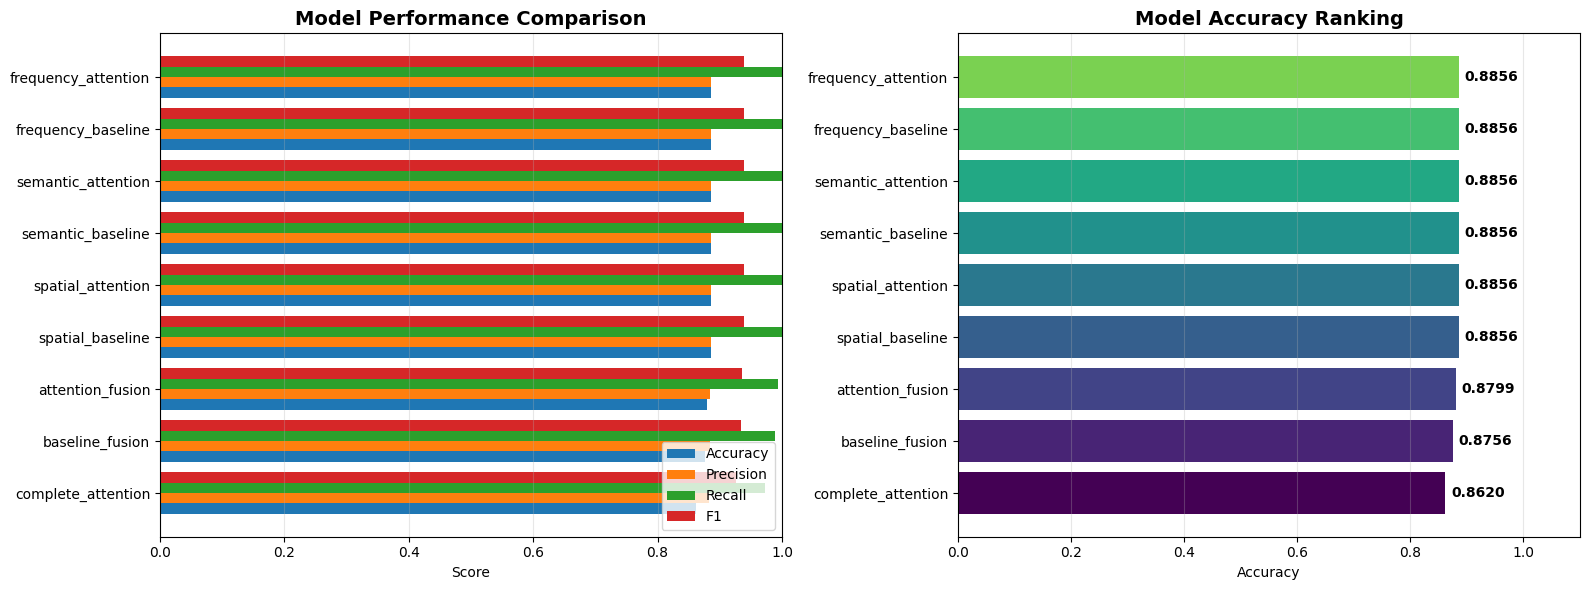

✓ Visualization saved to E:\deepfake_detection_project\results\model_comparison.png


In [51]:
# ============================================================================
# VISUALIZATION: MODEL COMPARISON CHART
# ============================================================================

if comparison_data:
    # Create grouped bar chart
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sort by accuracy for better visualization
    df_sorted = comparison_df.sort_values('accuracy', ascending=True)
    
    # Plot 1: All metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(df_sorted))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        axes[0].barh(x + i*width, df_sorted[metric], width, label=metric.capitalize())
    
    axes[0].set_yticks(x + width * 1.5)
    axes[0].set_yticklabels(df_sorted['model'])
    axes[0].set_xlabel('Score')
    axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].set_xlim([0, 1])
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Accuracy comparison with annotations
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(df_sorted)))
    bars = axes[1].barh(df_sorted['model'], df_sorted['accuracy'], color=colors)
    
    for bar, acc in zip(bars, df_sorted['accuracy']):
        axes[1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{acc:.4f}', va='center', fontweight='bold')
    
    axes[1].set_xlabel('Accuracy')
    axes[1].set_title('Model Accuracy Ranking', fontsize=14, fontweight='bold')
    axes[1].set_xlim([0, 1.1])
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualization saved to {config.RESULTS_DIR / 'model_comparison.png'}")

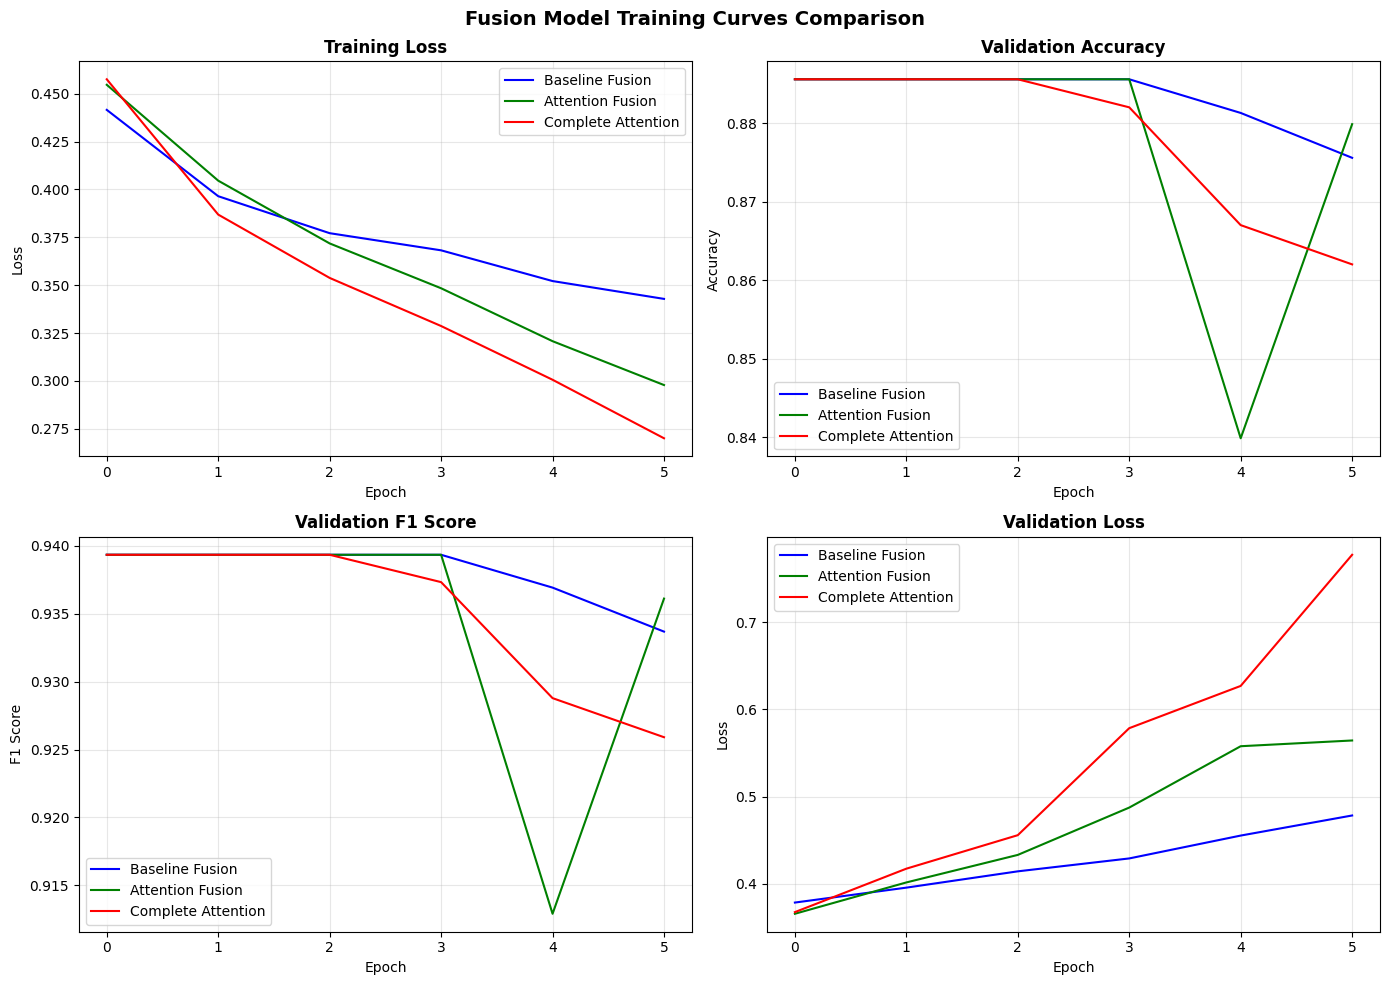

✓ Training curves saved to E:\deepfake_detection_project\results\training_curves.png


In [52]:
# ============================================================================
# VISUALIZATION: TRAINING CURVES
# ============================================================================

# Plot training curves for fusion models
fusion_models = ['baseline_fusion', 'attention_fusion', 'complete_attention']
available_fusion = [m for m in fusion_models if m in all_results]

if available_fusion:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = {'baseline_fusion': 'blue', 'attention_fusion': 'green', 'complete_attention': 'red'}
    labels = {'baseline_fusion': 'Baseline Fusion', 'attention_fusion': 'Attention Fusion', 'complete_attention': 'Complete Attention'}
    
    for model_name in available_fusion:
        history = all_results[model_name]['history']
        color = colors.get(model_name, 'gray')
        label = labels.get(model_name, model_name)
        
        # Training Loss
        axes[0, 0].plot(history['train_loss'], label=label, color=color)
        
        # Validation Accuracy
        axes[0, 1].plot(history['val_accuracy'], label=label, color=color)
        
        # Validation F1
        axes[1, 0].plot(history['val_f1'], label=label, color=color)
        
        # Validation Loss
        axes[1, 1].plot(history['val_loss'], label=label, color=color)
    
    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    axes[1, 0].set_title('Validation F1 Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.suptitle('Fusion Model Training Curves Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Training curves saved to {config.RESULTS_DIR / 'training_curves.png'}")

<a id='section10'></a>
## Section 10: Attention Analysis & Visualization

Analyze and visualize attention weights to understand model focus.

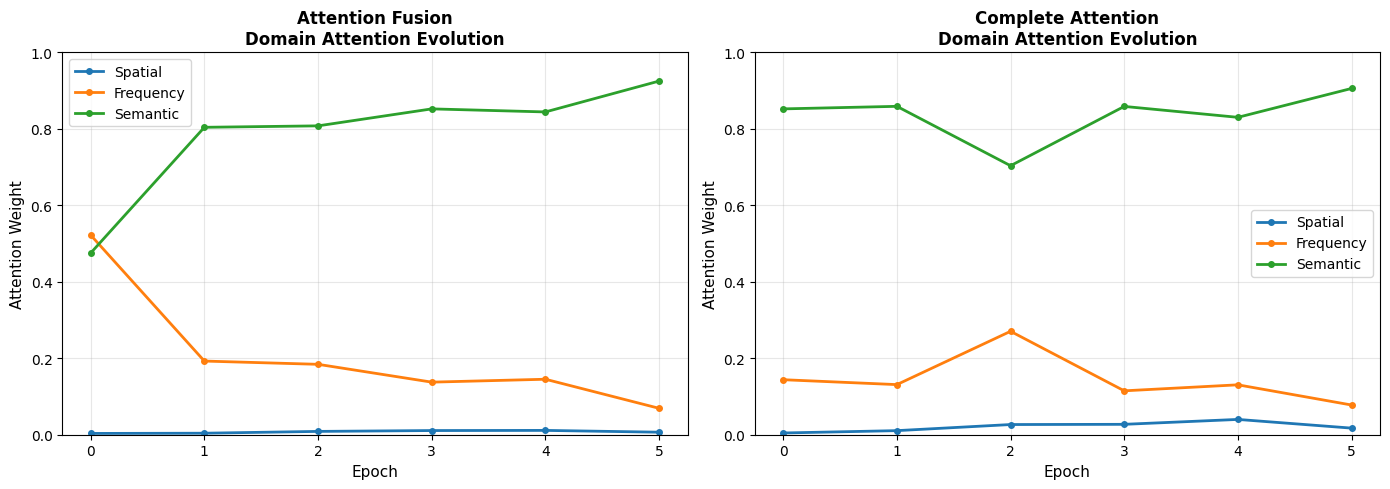

✓ Domain attention evolution saved


In [53]:
# ============================================================================
# DOMAIN ATTENTION WEIGHTS VISUALIZATION
# ============================================================================

# Find models with domain weights
attention_models = ['attention_fusion', 'complete_attention']
models_with_weights = [m for m in attention_models if m in all_results and all_results[m]['history'].get('domain_weights')]

if models_with_weights:
    fig, axes = plt.subplots(1, len(models_with_weights), figsize=(7*len(models_with_weights), 5))
    
    if len(models_with_weights) == 1:
        axes = [axes]
    
    domains = ['Spatial', 'Frequency', 'Semantic']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for ax, model_name in zip(axes, models_with_weights):
        weights_history = np.array(all_results[model_name]['history']['domain_weights'])
        
        # Plot evolution
        for i, (domain, color) in enumerate(zip(domains, colors)):
            ax.plot(weights_history[:, i], label=domain, color=color, linewidth=2, marker='o', markersize=4)
        
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Attention Weight', fontsize=11)
        ax.set_title(f'{model_name.replace("_", " ").title()}\nDomain Attention Evolution', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'domain_attention_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Domain attention evolution saved")
else:
    print("⚠ No models with domain attention weights available")

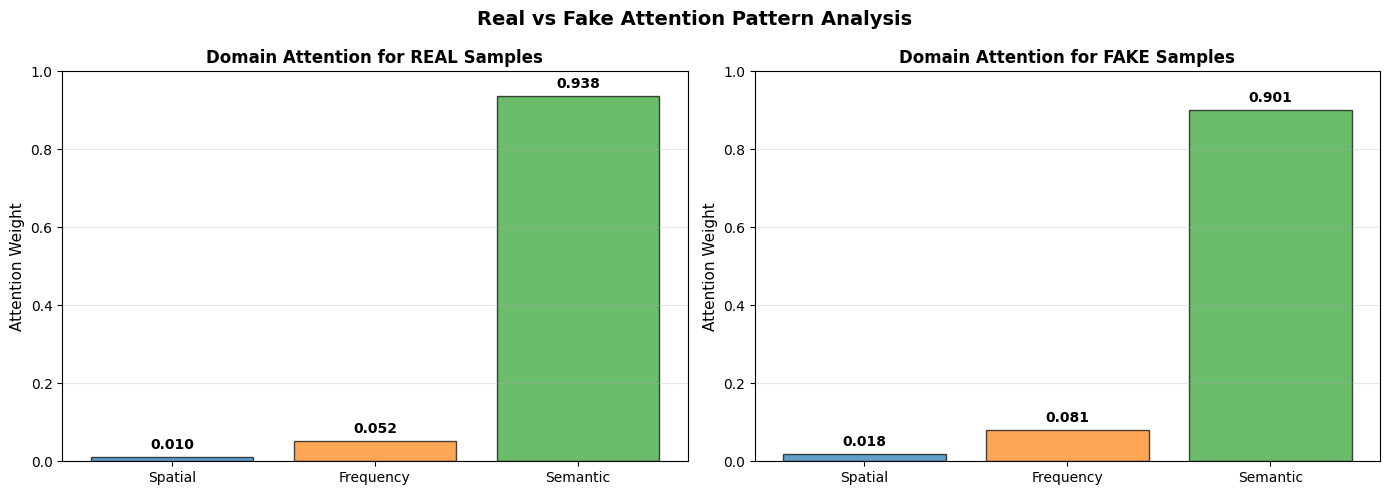


REAL VS FAKE ATTENTION ANALYSIS
Spatial     : Real=0.010, Fake=0.018, Diff=+0.008
Frequency   : Real=0.052, Fake=0.081, Diff=+0.029
Semantic    : Real=0.938, Fake=0.901, Diff=-0.037


In [54]:
# ============================================================================
# REAL VS FAKE ATTENTION ANALYSIS
# ============================================================================

def analyze_attention_by_class(model, model_name):
    """Analyze attention weights for real vs fake samples."""
    
    val_dataset = MultiDomainDataset(split='val')
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    model.eval()
    real_weights = []
    fake_weights = []
    
    with torch.no_grad():
        for spatial, freq, semantic, labels in val_loader:
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            
            _ = model(spatial, freq, semantic)
            
            if hasattr(model, 'last_domain_weights') and model.last_domain_weights is not None:
                weights = model.last_domain_weights.cpu().numpy()
                for i, label in enumerate(labels):
                    if label == 0:  # Real
                        real_weights.append(weights[i])
                    else:  # Fake
                        fake_weights.append(weights[i])
    
    if real_weights and fake_weights:
        real_avg = np.array(real_weights).mean(axis=0)
        fake_avg = np.array(fake_weights).mean(axis=0)
        
        return {'real': real_avg, 'fake': fake_avg}
    return None

# Analyze attention for complete attention model
if 'complete_attention' in all_results:
    model = all_results['complete_attention']['model']
    class_attention = analyze_attention_by_class(model, 'complete_attention')
    
    if class_attention:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        domains = ['Spatial', 'Frequency', 'Semantic']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        # Real samples
        bars1 = axes[0].bar(domains, class_attention['real'], color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_ylabel('Attention Weight', fontsize=11)
        axes[0].set_title('Domain Attention for REAL Samples', fontsize=12, fontweight='bold')
        axes[0].set_ylim([0, 1])
        axes[0].grid(axis='y', alpha=0.3)
        
        for bar, weight in zip(bars1, class_attention['real']):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{weight:.3f}', ha='center', fontweight='bold')
        
        # Fake samples
        bars2 = axes[1].bar(domains, class_attention['fake'], color=colors, alpha=0.7, edgecolor='black')
        axes[1].set_ylabel('Attention Weight', fontsize=11)
        axes[1].set_title('Domain Attention for FAKE Samples', fontsize=12, fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)
        
        for bar, weight in zip(bars2, class_attention['fake']):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{weight:.3f}', ha='center', fontweight='bold')
        
        plt.suptitle('Real vs Fake Attention Pattern Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.RESULTS_DIR / 'attention_real_vs_fake.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Print analysis
        print(f"\n{'='*70}")
        print("REAL VS FAKE ATTENTION ANALYSIS")
        print(f"{'='*70}")
        diff = class_attention['fake'] - class_attention['real']
        for domain, r, f, d in zip(domains, class_attention['real'], class_attention['fake'], diff):
            print(f"{domain:12s}: Real={r:.3f}, Fake={f:.3f}, Diff={d:+.3f}")
        print(f"{'='*70}")

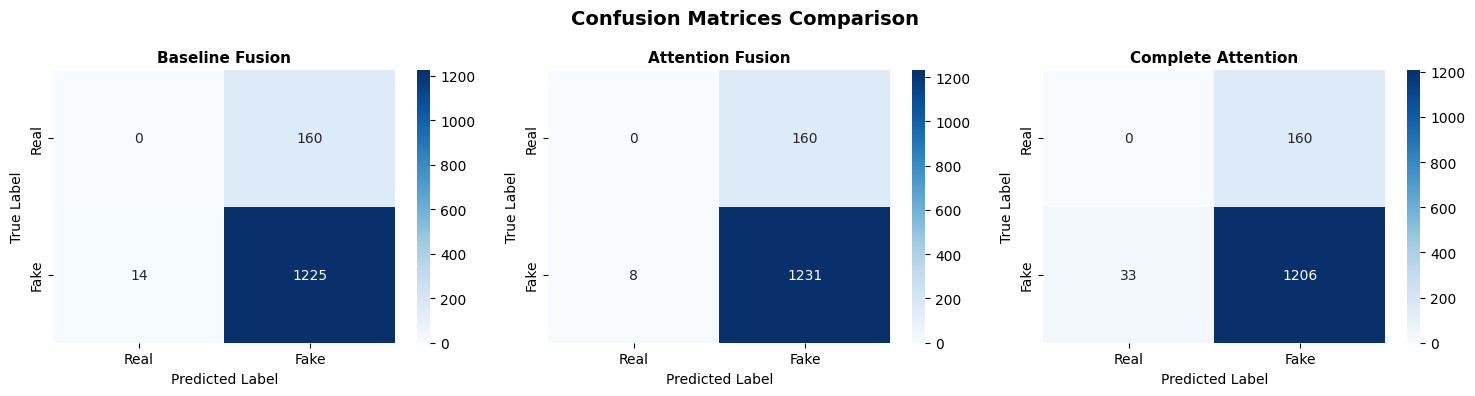

✓ Confusion matrices saved


In [55]:
# ============================================================================
# CONFUSION MATRICES
# ============================================================================

def plot_confusion_matrix(model, model_name, ax):
    """Generate and plot confusion matrix for a model."""
    
    val_dataset = MultiDomainDataset(split='val')
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for spatial, freq, semantic, labels in val_loader:
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            
            outputs = model(spatial, freq, semantic)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'], ax=ax)
    ax.set_title(f'{model_name.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Plot confusion matrices for fusion models
fusion_models = ['baseline_fusion', 'attention_fusion', 'complete_attention']
available = [m for m in fusion_models if m in all_results]

if available:
    n_models = len(available)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, model_name in zip(axes, available):
        plot_confusion_matrix(all_results[model_name]['model'], model_name, ax)
    
    plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Confusion matrices saved")

<a id='section11'></a>
## Section 11: Ablation Study

Analyze the contribution of each attention component.


ABLATION STUDY RESULTS
                      Component  Accuracy       F1
        Spatial Only (Baseline)  0.885633 0.939348
            Spatial + Attention  0.885633 0.939348
      Frequency Only (Baseline)  0.885633 0.939348
          Frequency + Attention  0.885633 0.939348
       Semantic Only (Baseline)  0.885633 0.939348
           Semantic + Attention  0.885633 0.939348
          Multi-Domain (Concat)  0.875625 0.933689
Multi-Domain + Fusion Attention  0.879914 0.936122
       Complete Attention (All)  0.862044 0.925912


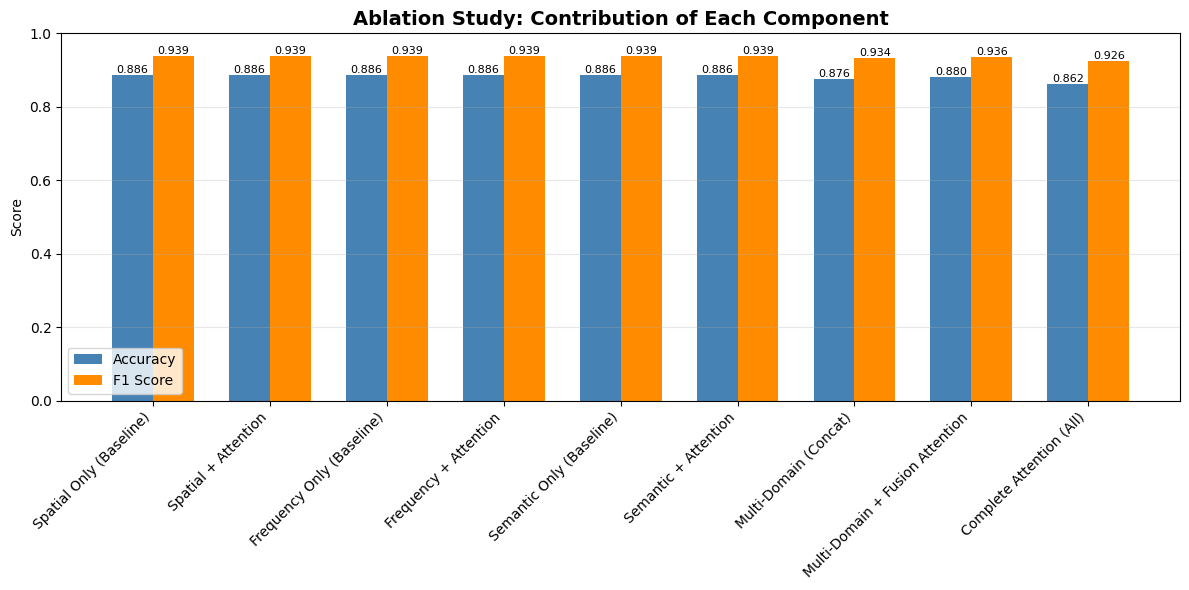


✓ Ablation study visualization saved


In [56]:
# ============================================================================
# ABLATION STUDY
# ============================================================================

# Prepare ablation data
ablation_data = []

# Individual domain baselines
for domain in ['spatial', 'frequency', 'semantic']:
    baseline_key = f'{domain}_baseline'
    attention_key = f'{domain}_attention'
    
    if baseline_key in all_results:
        ablation_data.append({
            'Component': f'{domain.capitalize()} Only (Baseline)',
            'Accuracy': all_results[baseline_key]['metrics']['accuracy'],
            'F1': all_results[baseline_key]['metrics']['f1']
        })
    
    if attention_key in all_results:
        ablation_data.append({
            'Component': f'{domain.capitalize()} + Attention',
            'Accuracy': all_results[attention_key]['metrics']['accuracy'],
            'F1': all_results[attention_key]['metrics']['f1']
        })

# Fusion models
if 'baseline_fusion' in all_results:
    ablation_data.append({
        'Component': 'Multi-Domain (Concat)',
        'Accuracy': all_results['baseline_fusion']['metrics']['accuracy'],
        'F1': all_results['baseline_fusion']['metrics']['f1']
    })

if 'attention_fusion' in all_results:
    ablation_data.append({
        'Component': 'Multi-Domain + Fusion Attention',
        'Accuracy': all_results['attention_fusion']['metrics']['accuracy'],
        'F1': all_results['attention_fusion']['metrics']['f1']
    })

if 'complete_attention' in all_results:
    ablation_data.append({
        'Component': 'Complete Attention (All)',
        'Accuracy': all_results['complete_attention']['metrics']['accuracy'],
        'F1': all_results['complete_attention']['metrics']['f1']
    })

if ablation_data:
    ablation_df = pd.DataFrame(ablation_data)
    
    print(f"\n{'='*80}")
    print("ABLATION STUDY RESULTS")
    print(f"{'='*80}")
    print(ablation_df.to_string(index=False))
    print(f"{'='*80}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(ablation_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, ablation_df['Accuracy'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, ablation_df['F1'], width, label='F1 Score', color='darkorange')
    
    ax.set_ylabel('Score')
    ax.set_title('Ablation Study: Contribution of Each Component', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(ablation_df['Component'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'ablation_study.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Ablation study visualization saved")

<a id='section12'></a>
## Section 12: Results Summary & Insights

Comprehensive summary of all findings and key insights.

In [57]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'#'*80}")
print("#" + " "*30 + "FINAL SUMMARY" + " "*35 + "#")
print(f"{'#'*80}")

print(f"\n{'='*80}")
print("1. DATASET INFORMATION")
print(f"{'='*80}")
print(f"  Dataset: FaceForensics++")
print(f"  Mode: {'Demo (' + str(config.DEMO_LIMIT) + ' videos/category)' if config.DEMO_LIMIT else 'Full dataset'}")
print(f"  Frames per video: {config.FRAMES_PER_VIDEO}")

print(f"\n{'='*80}")
print("2. FEATURE DOMAINS")
print(f"{'='*80}")
print(f"  Spatial (Xception): {config.SPATIAL_DIM} dimensions - Texture/artifact detection")
print(f"  Frequency (FFT): {config.FREQ_DIM} dimensions - Periodic pattern analysis")
print(f"  Semantic (DINOv2): {config.SEMANTIC_DIM} dimensions - High-level features")

print(f"\n{'='*80}")
print("3. ATTENTION MECHANISMS")
print(f"{'='*80}")
print("  Spatial: Channel Attention (Squeeze-and-Excitation)")
print("  Frequency: Frequency Band Attention")
print("  Semantic: Self-Attention")
print("  Fusion: Learnable Domain Attention Fusion")

print(f"\n{'='*80}")
print("4. MODEL PERFORMANCE RANKING")
print(f"{'='*80}")

if comparison_data:
    sorted_df = comparison_df.sort_values('accuracy', ascending=False)
    for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
        print(f"  {i}. {row['model']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}")

print(f"\n{'='*80}")
print("5. KEY INSIGHTS")
print(f"{'='*80}")

if comparison_data:
    best_model = sorted_df.iloc[0]['model']
    best_acc = sorted_df.iloc[0]['accuracy']
    
    # Calculate improvements
    baseline_acc = sorted_df[sorted_df['model'] == 'baseline_fusion']['accuracy'].values[0] if 'baseline_fusion' in sorted_df['model'].values else 0
    
    if 'complete_attention' in sorted_df['model'].values:
        attention_acc = sorted_df[sorted_df['model'] == 'complete_attention']['accuracy'].values[0]
        improvement = (attention_acc - baseline_acc) / baseline_acc * 100 if baseline_acc > 0 else 0
        print(f"  ✓ Best performing model: {best_model}")
        print(f"  ✓ Attention mechanism improvement: {improvement:+.2f}% over baseline fusion")

print(f"\n{'='*80}")
print("6. OUTPUT FILES")
print(f"{'='*80}")
print(f"  Checkpoints: {config.CHECKPOINTS_DIR}")
print(f"  Results: {config.RESULTS_DIR}")
print(f"  - model_comparison.csv: Performance comparison table")
print(f"  - model_comparison.png: Visual comparison chart")
print(f"  - training_curves.png: Training history plots")
print(f"  - confusion_matrices.png: Confusion matrices")
print(f"  - ablation_study.png: Component contribution analysis")

print(f"\n{'#'*80}")
print("#" + " "*25 + "EXPERIMENT COMPLETE" + " "*30 + "#")
print(f"{'#'*80}")


################################################################################
#                              FINAL SUMMARY                                   #
################################################################################

1. DATASET INFORMATION
  Dataset: FaceForensics++
  Mode: Demo (50 videos/category)
  Frames per video: 20

2. FEATURE DOMAINS
  Spatial (Xception): 2048 dimensions - Texture/artifact detection
  Frequency (FFT): 4 dimensions - Periodic pattern analysis
  Semantic (DINOv2): 768 dimensions - High-level features

3. ATTENTION MECHANISMS
  Spatial: Channel Attention (Squeeze-and-Excitation)
  Frequency: Frequency Band Attention
  Semantic: Self-Attention
  Fusion: Learnable Domain Attention Fusion

4. MODEL PERFORMANCE RANKING
  1. spatial_baseline: Acc=0.8856, F1=0.9393
  2. frequency_baseline: Acc=0.8856, F1=0.9393
  3. semantic_baseline: Acc=0.8856, F1=0.9393
  4. spatial_attention: Acc=0.8856, F1=0.9393
  5. frequency_attention: Acc=0.8856, F1=

In [58]:
# ============================================================================
# SAVE FINAL RESULTS
# ============================================================================

# Save comprehensive results
final_results = {
    'config': {
        'spatial_dim': config.SPATIAL_DIM,
        'freq_dim': config.FREQ_DIM,
        'semantic_dim': config.SEMANTIC_DIM,
        'epochs': config.EPOCHS,
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE
    },
    'models': {}
}

for name, result in all_results.items():
    if result and 'metrics' in result:
        final_results['models'][name] = result['metrics']

# Save as JSON
import json
with open(config.RESULTS_DIR / 'final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\n✓ Final results saved to {config.RESULTS_DIR / 'final_results.json'}")
print("\n" + "="*80)
print("All experiments completed successfully!")
print("="*80)


✓ Final results saved to E:\deepfake_detection_project\results\final_results.json

All experiments completed successfully!
